#Rejection sampling

We would like to get a "difficult" (target) distribution. For this purposes we can use a rejection sampling which utilizes some "easy" (proposal) distribution (eg. gaussian or uniform) by discarding some of the samples.

In this Jupyter notebook, I am going to implement a generator of Planck function distribution, which has next formula: $$L(v,t)=\frac{2hv^3}{c^2}\frac{1}{e^{\frac{hv}{k_BT}}-1},$$
where $L(v,t)$ is black body radiance,  $h$ is planck constant, $c$ is speed of light, $k_B$ is Boltzman constant, $v$ is frequency and $t$ is black body temperature.

##Initial setup

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
h = 6.62606957e-34 #planck constant
c = 299792458 #speed of light
k_B = 1.3806488e-23 #boltzman constant

min_freq = 100
max_freq = 1.5e14

In [3]:
L = lambda v, t: (2*h*v**3)/c**2/(np.exp(h*v/(k_B*t))-1)

##Graphical visualization

At first, lets look at how function looks like. I will generate a heat map since our function $L(v,t)$ is 3-dimensional.

In [4]:
v = np.linspace(min_freq, max_freq, 1000)
t = np.linspace(100, 500, 1000)

In [5]:
X, Y = np.meshgrid(v, t)
Z = L(X, Y)

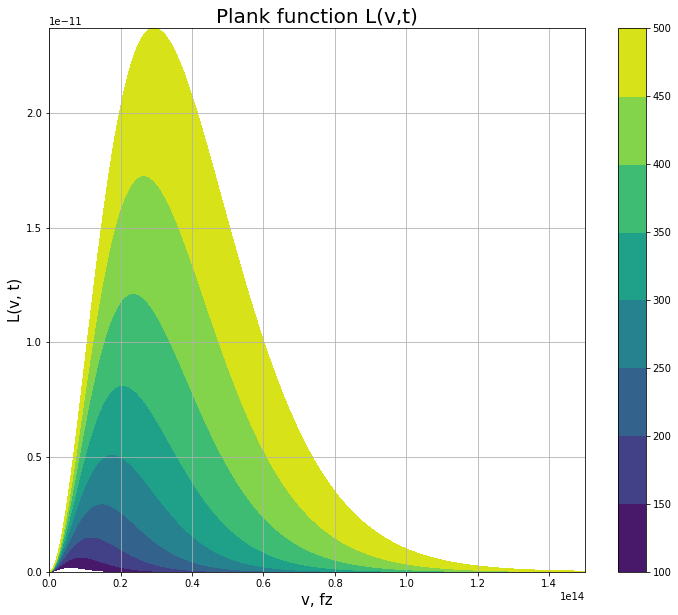

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
cp = ax.contourf(X, Z, Y)
fig.colorbar(cp) # Add a colorbar to a plot
  
#graph settings
ax.set_title('Plank function L(v,t)',fontsize=20)
ax.set_xlabel('v, fz',  fontsize=15)
ax.set_ylabel('L(v, t)',  fontsize=15)
plt.grid()
plt.show()

##Choosing proposal distribution

The main problem with rejection sampling is to choose proposal distribution. Right choice of proposed distribution gurantees less rejection rate.

To make things simpler, I will fix a temperature. 

As a proposal distribution, I have chosen uniform distribution, since the shape of the curve varies significantly with a different temperature. It may be challenging to define a formula for a constant $K$ to scale any other distribution so that it still fits any temperature.

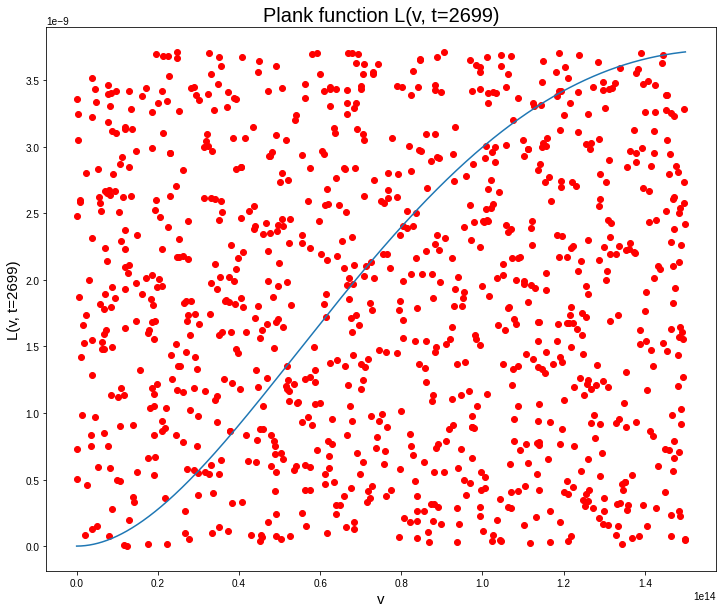

In [7]:
t_fixed = np.random.randint(100,5000)
Z_new = L(v, t_fixed)
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title(f'Plank function L(v, t={t_fixed})',fontsize=20)
ax.set_xlabel('v',  fontsize=15)
ax.set_ylabel(f'L(v, t={t_fixed})',  fontsize=15)
ax.plot(v, Z_new)

x = np.random.uniform(0, max_freq, 1000)
prop_uni = stats.uniform(0, max_freq)
K = max(L(x, t_fixed))/max(prop_uni.pdf(x))
u = np.random.uniform(0, K*prop_uni.pdf(x))
ax.scatter(x, u, color="red")
plt.style.use('seaborn-whitegrid')
plt.show()

##Creating a generator for planck function

In order to ensure that generator works correctly, I will also calculate expected acception rate.

In [8]:
def planck_generator(T, N, validation=False, max_n=10000):
    print(f"Planck function generator for T={T} and N={N}")

    
    x = np.random.uniform(0, max_freq, max_n)
    prop_uni = stats.uniform(0, max_freq)

    #I need to change formula a little bit for integratin purposes
    L = lambda v: (2*h*v**3)/c**2/(np.exp(h*v/(k_B*T))-1)

    #I need to identify scaling factor, so I need a maximum value of L(x)
    val = max(L(x))
    K = val/prop_uni.pdf(x[0])
    
    counter = 0
    
    #Expected acception rate is a ratio of areas under planck curve and 
    #are covered by uniform distribution
    #it will converge to experimental accception rate with increrasing number of samples
    uni_area = val * (max_freq-min_freq)
    planck_area = quad(L, min_freq, max_freq)[0]
    expected_rate = planck_area/uni_area
    
    #we need N samples, so search until found N acceptable samples
    generated = []

    while len(generated) < N:
        x = np.random.uniform(0, max_freq)
        u = np.random.uniform(0, K*prop_uni.pdf(x))
        val = L(x)
        if u<=val:
            generated.append(x)
        counter+=1
            
    acception_rate = len(generated)/counter

    if validation:
        print(f"Expected acception rate: {expected_rate},\nExperimental acception rate:{acception_rate}\n")

    return np.array(generated), expected_rate, acception_rate


In [9]:
N=10000
t_fixed = np.random.randint(100,5000)

samples, expected_rate, experimental_acception_rate = planck_generator(t_fixed, N, True)

Planck function generator for T=3499 and N=10000
Expected acception rate: 0.4757716362183101,
Experimental acception rate:0.478423117405033



I would like to know how experimental acception rate varies with $N$

In [10]:
def plot_generated_planck_func(ax, color, t_fixed, N):
    Z_new = L(v, t_fixed)
    ax.set_title(f'Plank function L(v, t)',fontsize=20)
    ax.set_xlabel('v',  fontsize=15)
    ax.set_ylabel(f'L(v, t)',  fontsize=15)
    ax.plot(v, Z_new, label = f"T = {t_fixed} K", color=color)
    samples = planck_generator(t_fixed, N, True)[0]
    ax.scatter(samples, L(samples, t_fixed), color=color)
    plt.style.use('seaborn-whitegrid')
    

Planck function generator for T=786 and N=1000
Expected acception rate: 0.4900734943133857,
Experimental acception rate:0.49925112331502747

Planck function generator for T=564 and N=1000
Expected acception rate: 0.3575103733095469,
Experimental acception rate:0.35410764872521244

Planck function generator for T=440 and N=1000
Expected acception rate: 0.2792170923466553,
Experimental acception rate:0.2737476047084588

Planck function generator for T=329 and N=1000
Expected acception rate: 0.20879144739433755,
Experimental acception rate:0.2106593638087213

Planck function generator for T=293 and N=1000
Expected acception rate: 0.18594506141607517,
Experimental acception rate:0.18800526414739613

Planck function generator for T=281 and N=1000
Expected acception rate: 0.1783295699093837,
Experimental acception rate:0.1869857890800299

Planck function generator for T=152 and N=1000
Expected acception rate: 0.09646297232839908,
Experimental acception rate:0.09190331770976932



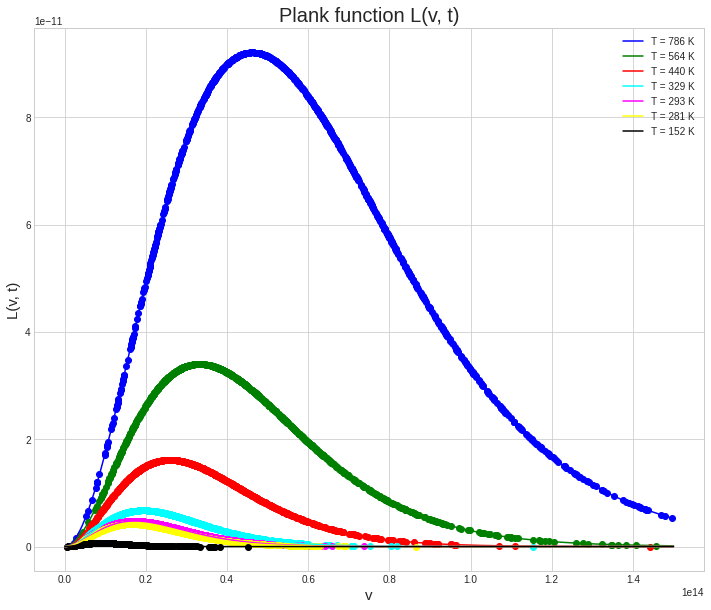

In [11]:
N = 1000
fig, ax = plt.subplots(figsize=(12, 10))
colors = ['blue','green',  'red', 'cyan', 'magenta', 'yellow', 'black']
T = np.random.randint(100, 1000, 7)
T.sort()

for color, t_fixed in zip(colors,T[::-1]):
    plot_generated_planck_func(ax, color, t_fixed, N)
    
plt.style.use('seaborn-whitegrid')   
ax.legend()
plt.show()

In this toy experiment we have an exact formula, but in future we will deal mostly with unsupervised learning. For a moment lets imagine that we don't have any formula for planck function, but the only thing that we posses are the frequences of observed particles.

We need a function for normalization, I will explain it later on in the comments:

In [12]:
def normalize(samples):
    #max-min normalization
    #after this normalization all values will be in range 0-1
    max_val = np.max(samples)
    min_val = np.min(samples)

    return (samples - min_val)/(max_val - min_val)

Now, our values for $L(v, T)$ are in range from 0 to 1 and they can be easily scaled.

In [13]:
N = 20
t_fixed = np.random.randint(100, 1000)
sample_frequences = planck_generator(t_fixed, N)[0]
sample_L = L(sample_frequences, t_fixed)
sample_L_normalized = normalize(sample_L)

print(f"Values before normalization:\n{sample_L}\nAfter normalization:\n{sample_L_normalized}")

Planck function generator for T=565 and N=20
Values before normalization:
[2.86812373e-11 1.95053592e-11 3.41744643e-11 1.81322749e-11
 3.40146860e-11 2.93078438e-11 2.18770574e-11 3.18223719e-11
 2.39586284e-11 1.87496199e-11 2.16290187e-11 2.12720189e-11
 2.64499506e-11 2.27944395e-11 3.41476171e-11 3.07632899e-11
 2.02652957e-11 1.12908234e-11 3.21783747e-11 8.55636074e-12]
After normalization:
[0.78557246 0.42739301 1.         0.37379481 0.99376307 0.81003198
 0.519972   0.90818632 0.60122591 0.39789281 0.51028984 0.49635439
 0.69847441 0.55578192 0.99895202 0.86684516 0.45705706 0.10673946
 0.92208285 0.        ]


Now, lets devide our range of frequencies into equidistant bins. 

In [14]:
def plot_bins_planck_func(num_bins, t_fixed, N):

    #generate data for graphs
    generated_samples = planck_generator(t_fixed, N, True)[0]
    true_samples = np.linspace(min_freq, max_freq, 1000)
    true_samples_L = normalize(L(v, t_fixed))

    #graph settings
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(f'Histogram of frequencies',fontsize=20)
    plt.style.use('seaborn-whitegrid') # nice and clean grid
    ax.set_xlabel('v',  fontsize=15)
    ax.set_ylabel(f'Frequency',  fontsize=15)

    #plot graphs
    #n returns number of particles at each bin
    n, bins, patches = ax.hist(generated_samples, bins = num_bins, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5,  label="Generated v")
    #scale our L to this number of particles
    ax.plot(true_samples, true_samples_L*(max(n)-min(n))+min(n), label = "Target v")

    ax.legend()
    plt.show()

Planck function generator for T=1000 and N=50000
Expected acception rate: 0.5924123895081045,
Experimental acception rate:0.590911776871713



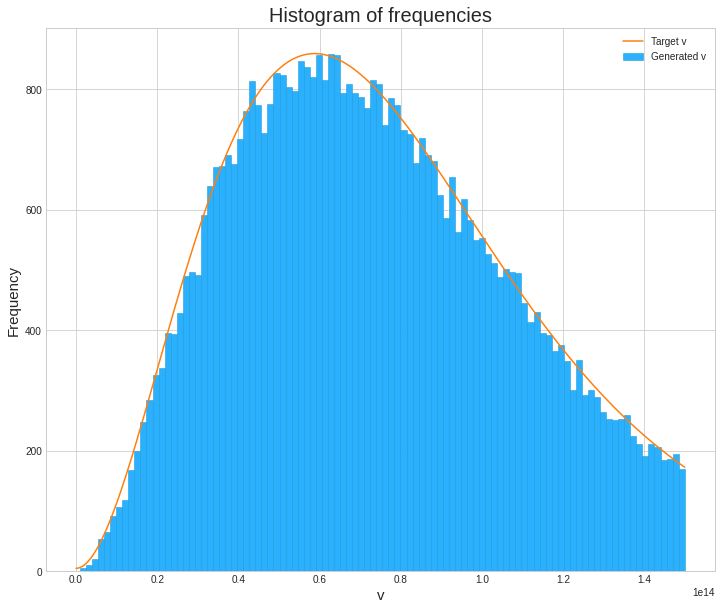

In [15]:
num_bins = 100
t_fixed = 1000
N = 50000

plot_bins_planck_func(num_bins, t_fixed, N)


With this toy experiment, we now can clearly see the problem that we try to solve. If we want to accurately approximate function, we need to generate more samples. But generating many samples is costly. More complex function require even more execution time. So, we would like to find a way to speed up the process.

#Approach 1 – Generate highier order statistic from small order statistic